In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from joblib import dump
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from scipy.stats import norm

### Final Project ###

Daniel Yao

EN.580.475

10 October 21

### Drafting in Brawl Stars ###

In this project, I predict the outcome of brawl stars matches given a draft. I use three models, a logistic regression, a random forest, and a neural network, and I compare the performances between these models.

### Data Exploration ###

I first inspect the data, displaying the (preprocessed) data, unique brawlers, and unique game modes. I then plot a heat map showing the win rates for each pair of brawlers in the data set. The heat map is sparse, as expected, so most possible match ups are not represented in the data set.

In [3]:
# set input/output paths
data_dir = os.path.join(os.getcwd(), '../data')
output_dir = os.path.join(os.getcwd(), '../output')
model_dir = os.path.join(os.getcwd(), '../models')

# load data from csv
try:
    file_path = os.path.join(data_dir, 'data.csv')
    df = pd.read_csv(file_path)
except Exception as e:
    df = pd.DataFrame()
    print(e)

print(df)

           mode        b1       b2      b3      r1              r2       r3  y
0       hotZone     BROCK     CROW    FANG  JESSIE  LARRY & LAWRIE    MR. P  1
1       hotZone     BROCK     CROW    FANG  JESSIE  LARRY & LAWRIE    MR. P  1
2      knockout  DYNAMIKE   SHELLY  SPROUT    GROM          MORTIS    PIPER  1
3      knockout  DYNAMIKE   SHELLY  SPROUT    GROM          MORTIS    PIPER  1
4        bounty      GENE    MANDY  SPROUT   BELLE           BYRON  MELODIE  0
...         ...       ...      ...     ...     ...             ...      ... ..
5509  brawlBall      CARL  CHESTER    COLT  BUSTER           BYRON     RICO  1
5510  brawlBall      CARL  CHESTER    COLT  BUSTER           BYRON     RICO  0
5511    gemGrab       MEG    PIPER  SPROUT   BELLE         CHESTER      PAM  0
5512    gemGrab       MEG    PIPER  SPROUT   BELLE         CHESTER      PAM  1
5513    gemGrab       MEG    PIPER  SPROUT   BELLE         CHESTER      PAM  0

[5514 rows x 8 columns]


In [4]:
# look at unique brawler names
names = pd.unique(df[['b1', 'b2', 'b3', 'r1', 'r2', 'r3']].values.ravel())
names.sort()

print(f'{len(names)} brawlers:')
print(names)

# save brawler names
pd.Series(names).to_csv(os.path.join(model_dir, 'names.csv'), index=False, header=False)

# look at unique game modes
modes = pd.unique(df[['mode']].values.ravel())
modes.sort()

print(f'{len(modes)} modes:')
print(modes)

# save game modes
pd.Series(modes).to_csv(os.path.join(model_dir, 'modes.csv'), index=False, header=False)

82 brawlers:
['8-BIT' 'AMBER' 'ANGELO' 'ASH' 'BARLEY' 'BEA' 'BELLE' 'BERRY' 'BIBI' 'BO'
 'BONNIE' 'BROCK' 'BULL' 'BUSTER' 'BUZZ' 'BYRON' 'CARL' 'CHARLIE'
 'CHESTER' 'CHUCK' 'CLANCY' 'COLETTE' 'COLT' 'CORDELIUS' 'CROW' 'DARRYL'
 'DOUG' 'DRACO' 'DYNAMIKE' 'EDGAR' 'EL PRIMO' 'EMZ' 'EVE' 'FANG' 'FRANK'
 'GALE' 'GENE' 'GRAY' 'GRIFF' 'GROM' 'GUS' 'HANK' 'JACKY' 'JANET' 'JESSIE'
 'KIT' 'LARRY & LAWRIE' 'LEON' 'LILY' 'LOLA' 'LOU' 'MAISIE' 'MANDY' 'MAX'
 'MEG' 'MELODIE' 'MICO' 'MORTIS' 'MR. P' 'NANI' 'NITA' 'OTIS' 'PAM'
 'PEARL' 'PENNY' 'PIPER' 'POCO' 'R-T' 'RICO' 'ROSA' 'RUFFS' 'SAM' 'SANDY'
 'SHELLY' 'SPIKE' 'SPROUT' 'SQUEAK' 'STU' 'SURGE' 'TARA' 'TICK' 'WILLOW']
6 modes:
['bounty' 'brawlBall' 'gemGrab' 'heist' 'hotZone' 'knockout']


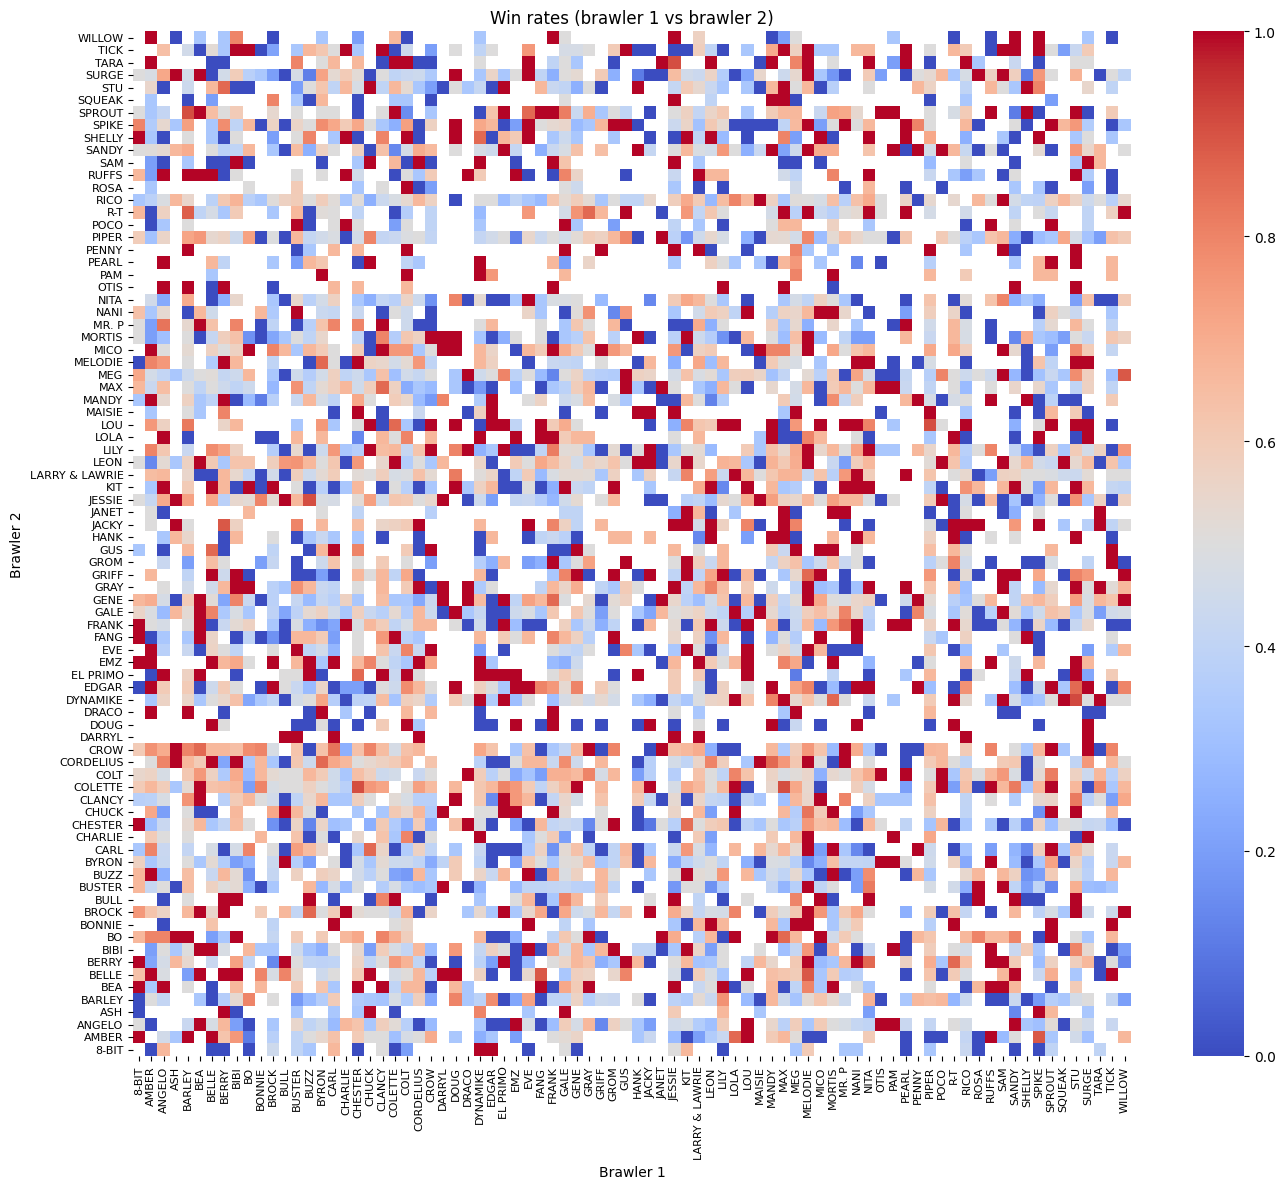

In [5]:
# create heat map for win rates between each pair of brawlers
games = []

# iterate through each game
for _, row in df.iterrows():
    team1 = [row['b1'], row['b2'], row['b3']]
    team2 = [row['r1'], row['r2'], row['r3']]

    # ierate through each pair of brawlers
    for b1, b2 in itertools.product(team1, team2):
        games.append({'b': b1, 'r': b2, 'y': int(row['y'] == 0)})

# create data frame of win rates
matchups = pd.DataFrame(games)
win_rates = matchups.groupby(['b', 'r'])['y'].mean().unstack(level='b')

# plot heatmap
plt.figure(figsize=(14, 12))
ax = sns.heatmap(win_rates, cmap='coolwarm', center=0.5)
ax.set_xticks(np.arange(len(win_rates.columns)) + 0.5)
ax.set_xticklabels(win_rates.columns, rotation=90, fontsize=8)
ax.set_yticks(np.arange(len(win_rates.index)) + 0.5)
ax.set_yticklabels(win_rates.index, rotation=0, fontsize=8)
ax.invert_yaxis()
plt.title('Win rates (brawler 1 vs brawler 2)')
plt.xlabel('Brawler 1')
plt.ylabel('Brawler 2')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'heatmap.png'))
plt.show()
plt.close()

### Encoding ###

The data are categorical, so I one-hot encode the game mode and brawlers. The preprocessed data have that brawlers are sorted within teams to respect order invariance within teams. (The order the brawlers are chosen does not affect the outcome of the game.)

In [22]:
# one-hot encode modes and brawlers
encoder = OneHotEncoder(
    categories=[
        modes,
        names,
        names,
        names,
        names, 
        names,
        names,],
    sparse_output=False)

X = df[['mode', 'b1','b2','b3','r1','r2','r3']]
X = encoder.fit_transform(X)

# save one-hot encoder
dump(encoder, os.path.join(model_dir, 'encoder.joblib'))

# split labels from predictors
y = df['y'].values

### Training/Testing ###

I split the data 80-20 training-testing without shuffling to prevent data leakage from one game to another game within a best of three match.

In [7]:
# split train-test 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(4411, 498) (1103, 498)
(4411,) (1103,)


### First try: logistic regression classifier ###

A logistic regression classifier is trained with L2 regularization. The operating point is selected to minimize the distance to the top-left corner of the ROC curve.

The training and testing performance are also displayed along with the respective confusion matrices. The model overfits to the training data. It achieves 66\% accuracy in training but only 56% accuracy in testing.

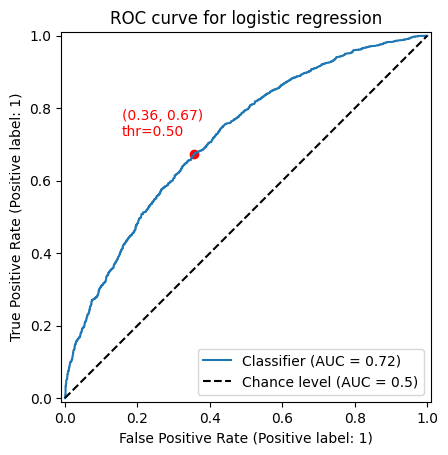

In [8]:
# first try: logistic regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

# save model
dump(lr_model, os.path.join(model_dir, 'lr.joblib'))

# find operating point
y_proba = lr_model.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_proba)
dist = np.square(fpr) + np.square(1-tpr)
op_idx = np.argmin(dist)
lr_op_pnt = thresholds[op_idx]

# plot roc curve
RocCurveDisplay.from_predictions(y_train, y_proba, plot_chance_level=True)
plt.scatter(fpr[op_idx], tpr[op_idx], color='red')
plt.text(fpr[op_idx] - 0.2, tpr[op_idx] + 0.05,
         f'({fpr[op_idx]:.2f}, {tpr[op_idx]:.2f})\nthr={thresholds[op_idx]:.2f}',
         color='red', fontsize=10)
plt.title('ROC curve for logistic regression')
plt.show()
plt.close()

In [9]:
# report training performance
y_hat_train = (lr_model.predict_proba(X_train)[:, 1] > lr_op_pnt)

print('Training performance:')
print(classification_report(y_train, y_hat_train))

# report testing performance
y_hat_test = (lr_model.predict_proba(X_test)[:, 1] > lr_op_pnt)

print('Testing performance:')
print(classification_report(y_test, y_hat_test))

Training performance:
              precision    recall  f1-score   support

           0       0.66      0.64      0.65      2200
           1       0.66      0.67      0.66      2211

    accuracy                           0.66      4411
   macro avg       0.66      0.66      0.66      4411
weighted avg       0.66      0.66      0.66      4411

Testing performance:
              precision    recall  f1-score   support

           0       0.55      0.55      0.55       548
           1       0.56      0.57      0.56       555

    accuracy                           0.56      1103
   macro avg       0.56      0.56      0.56      1103
weighted avg       0.56      0.56      0.56      1103



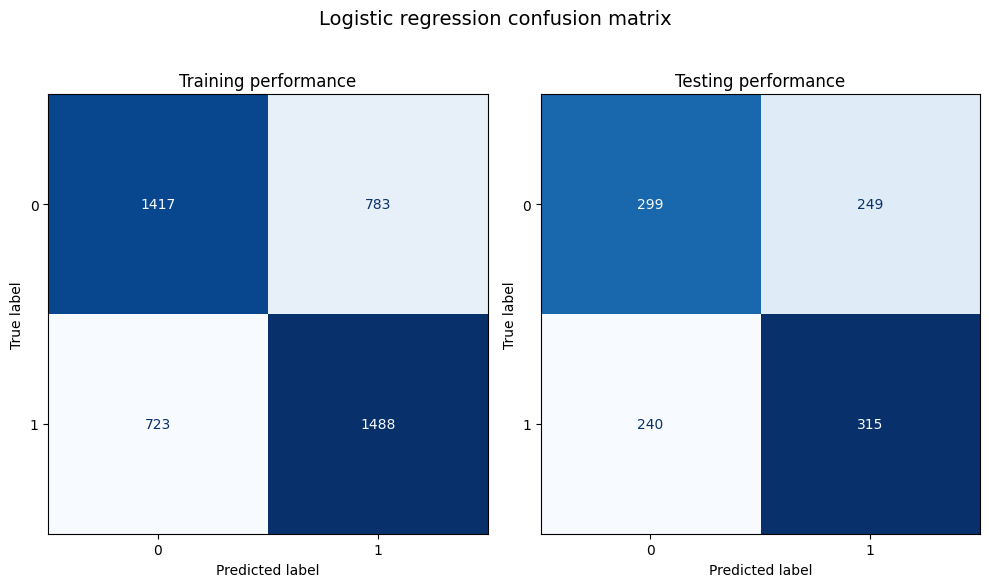

In [10]:
# plot confusion matrices
cm_train = confusion_matrix(y_train, y_hat_train)
cm_test  = confusion_matrix(y_test, y_hat_test)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

titles = ['Training performance', 'Testing performance']
cms = [cm_train, cm_test]
data = [(y_train, y_hat_train), (y_test, y_hat_test)]

for ax, cm, title in zip(axes, cms, titles):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(title)

plt.suptitle('Logistic regression confusion matrix', fontsize=14)
plt.savefig(os.path.join(output_dir, 'lr_confusion_matrix.png'))
plt.tight_layout()
plt.show()
plt.close()

### Second try: random forest classifier ###

A random forest classifier is trained with 20 trees and Gini impurity criterion. The number of trees is determined empirically. It is found that a small model of 20 trees performs the best. The operating point is selected to minimize the distance to the top-left corner of the ROC curve.

The training and testing performance are also displayed along with the respective confusion matrices. The random forest model overfits to the training data more so than the logistic regression model. The random forest model achieves 87\% accuracy in training but only 55% accuracy in testing.

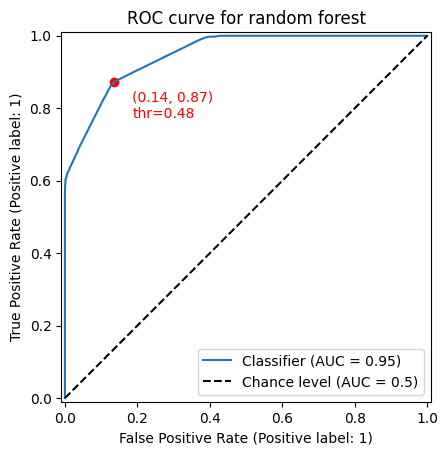

In [11]:
# second try: random forest
rf_model = RandomForestClassifier(n_estimators=20, random_state=42)
rf_model.fit(X_train, y_train)

# save model
dump(rf_model, os.path.join(model_dir, 'rf.joblib'))

# find operating point
y_proba = rf_model.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_proba)
dist = np.square(fpr) + np.square(1-tpr)
op_idx = np.argmin(dist)
rf_op_pnt = thresholds[op_idx]

# plot roc curve
RocCurveDisplay.from_predictions(y_train, y_proba, plot_chance_level=True)
plt.scatter(fpr[op_idx], tpr[op_idx], color='red')
plt.text(fpr[op_idx] + 0.05, tpr[op_idx] - 0.1,
         f'({fpr[op_idx]:.2f}, {tpr[op_idx]:.2f})\nthr={thresholds[op_idx]:.2f}',
         color='red', fontsize=10)
plt.title('ROC curve for random forest')
plt.show()
plt.close()

In [12]:
# report training performance
y_hat_train = (rf_model.predict_proba(X_train)[:, 1] > rf_op_pnt)

print('Training performance:')
print(classification_report(y_train, y_hat_train))

# report testing performance
y_hat_test = (rf_model.predict_proba(X_test)[:, 1] > rf_op_pnt)

print('Testing performance:')
print(classification_report(y_test, y_hat_test))

Training performance:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      2200
           1       0.87      0.87      0.87      2211

    accuracy                           0.87      4411
   macro avg       0.87      0.87      0.87      4411
weighted avg       0.87      0.87      0.87      4411

Testing performance:
              precision    recall  f1-score   support

           0       0.54      0.53      0.54       548
           1       0.55      0.56      0.56       555

    accuracy                           0.55      1103
   macro avg       0.55      0.55      0.55      1103
weighted avg       0.55      0.55      0.55      1103



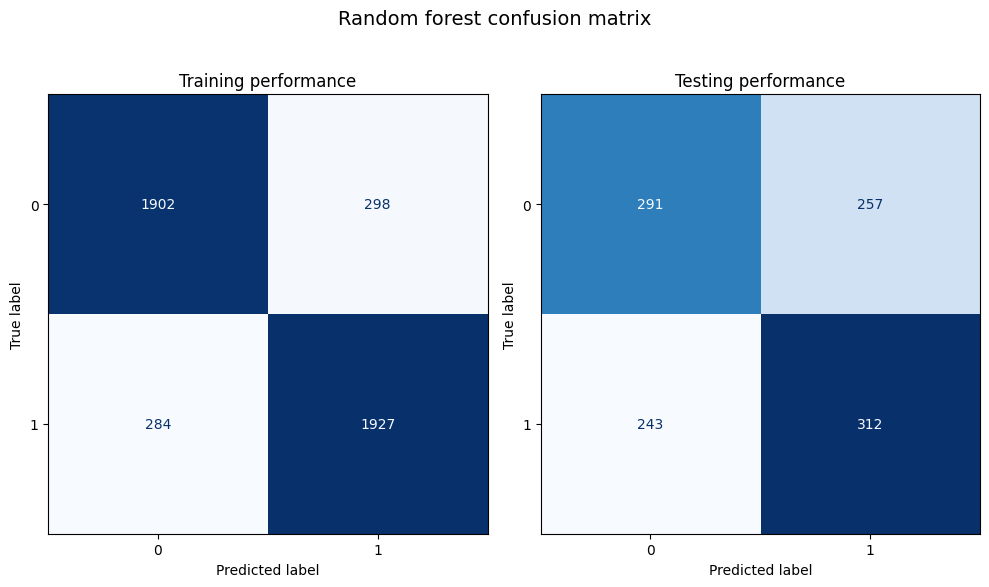

In [13]:
# plot confusion matrices
cm_train = confusion_matrix(y_train, y_hat_train)
cm_test  = confusion_matrix(y_test, y_hat_test)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

titles = ['Training performance', 'Testing performance']
cms = [cm_train, cm_test]
data = [(y_train, y_hat_train), (y_test, y_hat_test)]

for ax, cm, title in zip(axes, cms, titles):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(title)

plt.suptitle('Random forest confusion matrix', fontsize=14)
plt.savefig(os.path.join(output_dir, 'rf_confusion_matrix.png'))
plt.tight_layout()
plt.show()
plt.close()

### Third try: neural network classifier ###

A neural network is trained with two hidden layers of 32 neurons, ReLU activations, sigmoid output, and BCE loss. The number and size of the hidden layers is determined empirically. It is found that a small model of two hidden layers of 32 neurons performs the best. The operating point is selected to minimize the distance to the top-left corner of the ROC curve.

The training and testing performance are also displayed along with the respective confusion matrices. The random forest model overfits to the training data more so than the logistic regression model. The random forest model achieves 87\% accuracy in training but only 54% accuracy in testing.

In [14]:
# convert data to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

torch.Size([4411, 498]) torch.Size([1103, 498])
torch.Size([4411, 1]) torch.Size([1103, 1])


In [15]:
# define neural network architecture
class Net(nn.Module):
    # two hidden layers of 32 neurons, ReLU activations, sigmoid output
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(input_dim, 32), nn.ReLU(), nn.Linear(32, 1), nn.Sigmoid())
    
    def forward(self, x):
        return self.net(x)

100%|██████████| 512/512 [00:03<00:00, 144.95it/s]


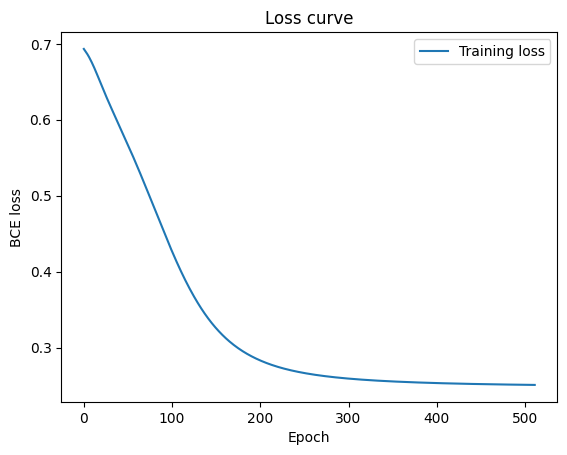

In [16]:
# third try: neural network
torch.manual_seed(42)

# create neural network
nn_model = Net(X_train.shape[1])
optimizer = torch.optim.Adam(nn_model.parameters(), lr=3e-3)
loss_fn = nn.BCELoss()

# track training loss
training_loss = []

# train model
num_epochs = 512

for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    y_pred = nn_model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()
    optimizer.step()

    epoch_loss = loss.item()
    training_loss.append(epoch_loss)

# save model
torch.save(nn_model, os.path.join(model_dir, 'nn.pth'))

# plot training loss
plt.figure()
plt.plot(range(num_epochs), training_loss)
plt.title('Loss curve')
plt.legend(['Training loss'])
plt.xlabel('Epoch')
plt.ylabel('BCE loss')
plt.savefig(os.path.join(output_dir, 'nn_loss_curve.png'))
plt.show()
plt.close()

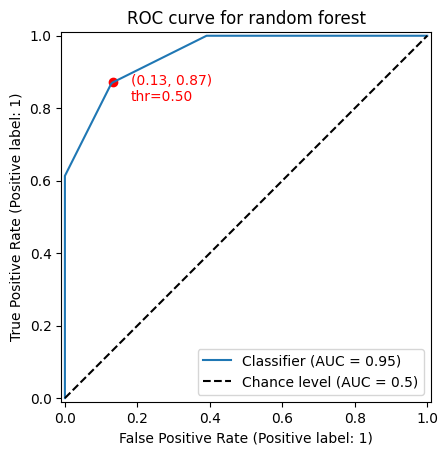

In [17]:
# find operating point
with torch.no_grad():
    y_proba = nn_model(X_train).numpy()

fpr, tpr, thresholds = roc_curve(y_train, y_proba)
dist = np.square(fpr) + np.square(1-tpr)
op_idx = np.argmin(dist)
nn_op_pnt = thresholds[op_idx]

# plot roc curve
RocCurveDisplay.from_predictions(y_train, y_proba, plot_chance_level=True)
plt.scatter(fpr[op_idx], tpr[op_idx], color='red')
plt.text(fpr[op_idx] + 0.05, tpr[op_idx] - 0.05,
         f'({fpr[op_idx]:.2f}, {tpr[op_idx]:.2f})\nthr={thresholds[op_idx]:.2f}',
         color='red', fontsize=10)
plt.title('ROC curve for random forest')
plt.show()
plt.close()

In [18]:
# report training performance
with torch.no_grad():
    y_proba = nn_model(X_train).numpy()

y_hat_train = (y_proba > nn_op_pnt).astype(int)

print('Training performance:')
print(classification_report(y_train, y_hat_train))

# report testing performance
with torch.no_grad():
    y_proba = nn_model(X_test).numpy()

y_hat_test = (y_proba > nn_op_pnt).astype(int)

print('Testing performance:')
print(classification_report(y_test, y_hat_test))

Training performance:
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87      2200
         1.0       0.87      0.87      0.87      2211

    accuracy                           0.87      4411
   macro avg       0.87      0.87      0.87      4411
weighted avg       0.87      0.87      0.87      4411

Testing performance:
              precision    recall  f1-score   support

         0.0       0.54      0.52      0.53       548
         1.0       0.54      0.57      0.56       555

    accuracy                           0.54      1103
   macro avg       0.54      0.54      0.54      1103
weighted avg       0.54      0.54      0.54      1103



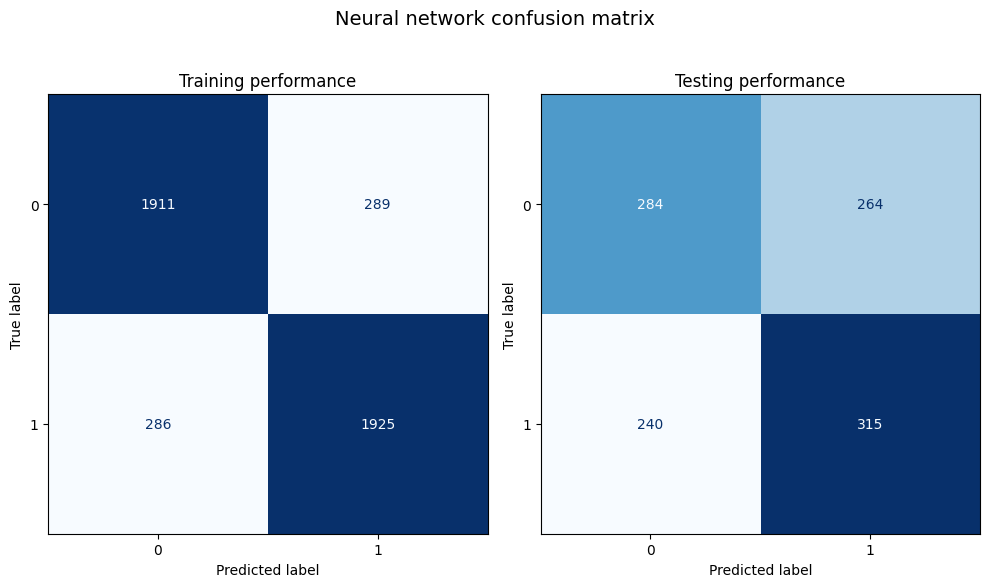

In [19]:
# plot confusion matrices
cm_train = confusion_matrix(y_train, y_hat_train)
cm_test  = confusion_matrix(y_test, y_hat_test)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

titles = ['Training performance', 'Testing performance']
cms = [cm_train, cm_test]
data = [(y_train, y_hat_train), (y_test, y_hat_test)]

for ax, cm, title in zip(axes, cms, titles):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(title)

plt.suptitle('Neural network confusion matrix', fontsize=14)
plt.savefig(os.path.join(output_dir, 'nn_confusion_matrix.png'))
plt.tight_layout()
plt.show()
plt.close()

### Performance comparison ###

I compare the performance of the three models.

The testing accuracies of each of the three models are shown with 95\% confidence intervals (computed as binomial distributions). A baseline positive rate reference is shown, which depicts the accuracy of always predicting the (training set) majority class. All three models perform with roughly 50\% accuracy, which is significantly better than the baseline positive rate at a significance level of $\alpha = 0.05$. The performance between the models is indistinguishable at a sifnificance level of $\alpha = 0.05$.

The $R^{2}$ of each of the models for the testing set is shown with 95\% confidence intervals (computed as squared t-distributions) in Figure. The $R^{2}$ is computed as 
$$R^{2} = 1 - \frac{y^{T}\hat{y}}{y^{T}y},$$
where $y$ is the vector of true labels and $\hat{y}$ is the vector of predicted probabilities. This value roughly corresponds to the proportion of variance explained by the model. The models explain 1-2\% of the total variance, which is significant at a significance level of $\alpha = 0.05$. The performance between the models is indistinguishable at a significance level of $\alpha = 0.05$.

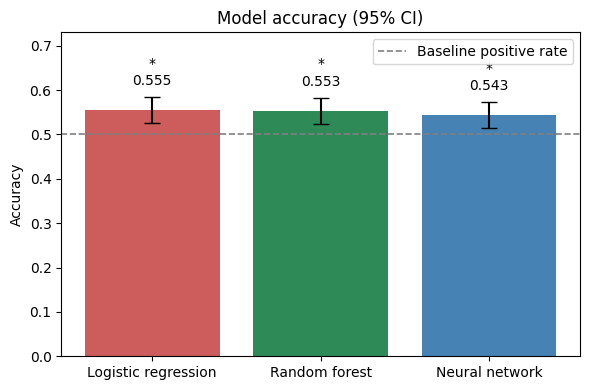

In [20]:
# switch to numpy
if torch.is_tensor(y_train):
    y_train = y_train.detach().numpy()

if torch.is_tensor(y_test):
    test = y_test.detach().numpy()

y_train = y_train.flatten()
y_test = y_test.flatten()

# evaluate logistic regression
y_pred_lr = (lr_model.predict_proba(X_test)[:, 1] > 0.5).astype(int)
acc_lr = accuracy_score(y_test, y_pred_lr)

# evaluate random forest
y_pred_rf = (rf_model.predict_proba(X_test)[:, 1] > 0.5).astype(int)
acc_rf = accuracy_score(y_test, y_pred_rf)

# evaluate neural network
with torch.no_grad():
    y_proba_nn = nn_model(X_test).numpy().flatten()
    y_pred_nn = (y_proba_nn > 0.5).astype(int)

acc_nn = accuracy_score(y_test.flatten(), y_pred_nn)

# compute 95% confidence intervals
alpha = 0.05
z = 1.96

accs = np.array([acc_lr, acc_rf, acc_nn])
cis = z * np.sqrt((accs * (1 - accs)) / len(y_test))

# compute baseline positive rate
p_majority = np.mean(y_train)
acc_chance = max(p_majority, 1-p_majority)

# plot accuracy bars
models = ['Logistic regression', 'Random forest', 'Neural network']

plt.figure(figsize=(6, 4))
bars = plt.bar(models, accs, yerr=cis, capsize=6, color=['indianred', 'seagreen', 'steelblue'])

# plot baseline positive rate
plt.axhline(acc_chance, color='gray', linestyle='--', linewidth=1.2, label='Baseline positive rate')

for bar, val in zip(bars, accs):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.05,
             f'{val:.3f}', ha='center', va='bottom')

plt.ylabel('Accuracy')
plt.title('Model accuracy (95% CI)')
plt.ylim(0, 1.25 * max(accs + cis))
plt.legend()

# mark statistical significance
for i, (bar, acc, ci) in enumerate(zip(bars, accs, cis)):
    if acc - ci > acc_chance:
        plt.text(bar.get_x() + bar.get_width()/2, acc + ci + 0.06, '*', 
                 ha='center', va='bottom')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'acc.png'))
plt.show()

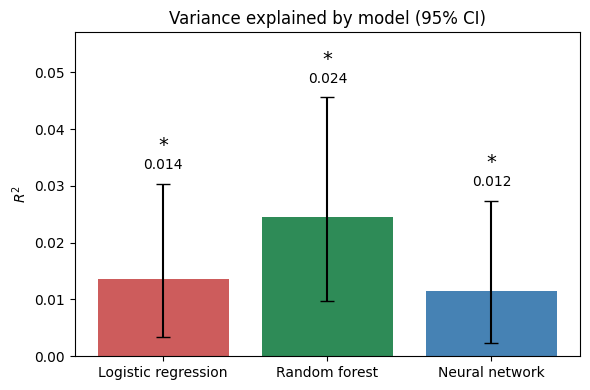

In [21]:
# switch to numpy
if torch.is_tensor(y_train):
    y_train = y_train.detach().numpy()

if torch.is_tensor(y_test):
    test = y_test.detach().numpy()

y_train = y_train.flatten()
y_test = y_test.flatten()

# compute R^2 values
r2_lr = np.corrcoef(y_test.flatten(), lr_model.predict_proba(X_test)[:, 1].flatten())[0, 1] ** 2
r2_rf = np.corrcoef(y_test.flatten(), rf_model.predict_proba(X_test)[:, 1].flatten())[0, 1] ** 2

with torch.no_grad():
    y_proba = nn_model(X_test).numpy()
r2_nn = np.corrcoef(y_test.flatten(), y_proba.flatten())[0, 1] ** 2

r2s = np.array([r2_lr, r2_rf, r2_nn])

# compute 95% confidence intervals via Fisher z-transform
n = len(y_test)
alpha = 0.05
zcrit = norm.ppf(1 - alpha/2)

rs = np.sign(r2s) * np.sqrt(r2s)
z = np.arctanh(rs)
se = 1 / np.sqrt(n - 3)
z_ci = np.array([z - zcrit * se, z + zcrit * se])
r_ci = np.tanh(z_ci)
r2_ci = np.sort(r_ci ** 2, axis=0)

ci_lower, ci_upper = r2_ci

# plot R^2 bars
models = ['Logistic regression', 'Random forest', 'Neural network']

plt.figure(figsize=(6, 4))
bars = plt.bar(models, r2s, yerr=[r2s - ci_lower, ci_upper - r2s],
               capsize=5, color=['indianred', 'seagreen', 'steelblue'],)

for bar, val, hi in zip(bars, r2s, ci_upper):
    plt.text(bar.get_x() + bar.get_width()/2, hi + 0.002,
             f'{val:.3f}', ha='center', va='bottom')

plt.ylabel('$R^2$')
plt.title('Variance explained by model (95% CI)')
plt.ylim(0, max(ci_upper)*1.25)

# mark statistical significance
for bar, lo, hi in zip(bars, ci_lower, ci_upper):
    if lo > 0:
        plt.text(bar.get_x() + bar.get_width()/2, hi + 0.005, '*',
                 ha='center', va='bottom', fontsize=14, color='black')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'r2.png'))
plt.show()


### Discussion and conclusions ###

Each of the three models performs better than randomly guessing and explain a non-zero amount of variance. No model achieves very high accuracy, but this is expected because the draft is not the only factor that determines the outcome of a game.

Strong conclusions are hard to draw from these results. There are many confounders at play. Though the outcome of a match can be predicted better than chance from only the draft, there is the possibility that players who are better mechanically are also better draft-wise. Nevertheless, a rough heuristic yields that these data are compatible with the explanation that (at least) 10\% of games are determined entirely by the draft while the other (at most) 90\% of games are determined entirely by mechanics. This roughly matches my experience from playing the game.

Another limiation is that the data only included 5,414 games, while there are 
$$\binom{82}{3,3,76} \big/ 2 = 3,501,618,120$$
total match ups (A vs B is identical to B vs A). As such, almost all possible match ups are not represented in the data set. The models therefore operates almost entirely out of distribution. Nevertheless, the all three of the models are able to generalize to unseen data with better-than-guessing performances.

A final limitation is that the choice of brawlers is very map dependent even within a game mode. To reduce the dimensionality of the state space, I aggregated the maps within each game mode. However, to those familiar with the game, this may not be reasonable. This limitation could be resolved with more data.

In this project, I predict the outcome of Brawl Stars matches given a draft. I demonstrate that a logistic regression, a random forest, and a neural network model each perform significantly better than guessing but they do not perform significantly differently from each other, each achieving roughly 55\% accuracy in testing.